In [99]:
import statsmodels.tsa.holtwinters as hw
import statsmodels.tsa.statespace.exponential_smoothing as hw_ss
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.optimize import curve_fit
import datetime as dt
import matplotlib.pyplot as plt

In [72]:
us_data = pd.read_csv("../covid-tracking-data/data/us_daily.csv", index_col="date", parse_dates=["date"])[::-1]

#start_date = pd.to_datetime("20200228")
#end_date = pd.to_datetime   ("20200420")
#end_date = us_data.index[-1]
#us_data = us_data[(us_data.index >= start_date) & (us_data.index <= end_date)]

In [73]:
us_data

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6f126ac272c96ac177c9e7a012c1ad72635ef468,2020-01-22T21:00:00Z,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN
2020-01-23,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,990a02f183bd45edc0cc64e2e9cee81ade44e1d5,2020-01-23T21:00:00Z,NaN,NaN,1,1,1,0.0,0.0,0.0,0.0,0.0
2020-01-24,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,df62af08ca19261e649a2956caaa742afa10fba4,2020-01-24T21:00:00Z,NaN,NaN,1,1,1,0.0,0.0,0.0,0.0,0.0
2020-01-25,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3397c4f4ae5bca7147c616b98530b573a34d53fe,2020-01-25T21:00:00Z,NaN,NaN,1,1,1,0.0,0.0,0.0,0.0,0.0
2020-01-26,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49d7f7395cd6355c1cfd73e8f987b880a23b0806,2020-01-26T21:00:00Z,NaN,NaN,1,1,1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-21,56,800305,3355282.0,3956.0,58468.0,84292.0,15228.0,2315.0,5514.0,214.0,58117.0,3b6ac24c144484eac7903d9b5bf045403557cb79,2020-04-21T20:00:00Z,39995.0,84292.0,4159543,4155587,4155587,2674.0,1413.0,124255.0,27285.0,151540.0
2020-04-22,56,827963,3641232.0,4191.0,58173.0,85543.0,15341.0,2370.0,5474.0,227.0,61519.0,10950b0a5f0f5d131a171fc67ac74556bbfe8a57,2020-04-22T20:00:00Z,42128.0,85543.0,4473386,4469195,4469195,2133.0,1251.0,285950.0,27658.0,313608.0
2020-04-23,56,859318,3800932.0,4258.0,57879.0,91108.0,15163.0,2428.0,5464.0,227.0,63547.0,f8d0b55808034b1ea448c7f77be00e8c7a207d48,2020-04-23T20:00:00Z,44014.0,91108.0,4664508,4660250,4660250,1886.0,5565.0,159700.0,31355.0,191055.0


In [115]:
#end_date = pd.to_datetime('20200420')
end_date = us_data.index[-1]

params = []
for t, d in [('mul', True), ('mul', False), ('add', True), ('add', False)]:
    es = hw.ExponentialSmoothing(
        us_data['positive'][(us_data.index <= end_date)],
        trend=t,
        freq='D',
        damped=d,
    )
    fit = es.fit()
    params.append((fit.sse, fit, es, t, d))
    print("Trend: %s, Damped: %s, SSE: %f" % (t,d,fit.sse))
    
best = min(params)
best_fit = best[1]
best_model = best[2]
print('Selecting: Trend: %s, Damped: %s, SSE: %f ' % (best[3], best[4], best[0]))

Trend: mul, Damped: True, SSE: 383200720.275650
Trend: mul, Damped: False, SSE: 468382969.443735
Trend: add, Damped: True, SSE: 376037443.377145
Trend: add, Damped: False, SSE: 375907612.191279
Selecting: Trend: add, Damped: False, SSE: 375907612.191279 


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


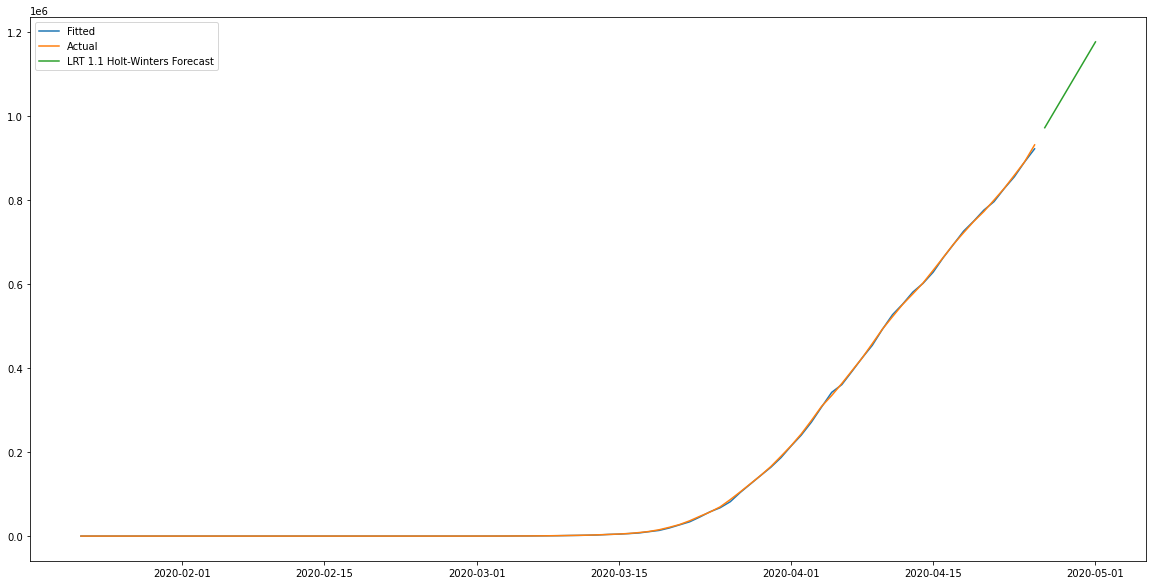

In [113]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(best_fit.fittedvalues, label="Fitted")
ax.plot(us_data['positive'], label="Actual")

ax.plot(best_fit.forecast(6), label="LRT 1.1 Holt-Winters Forecast")
plt.legend()

#fit1.params_formatted

In [133]:
best_fit.forecast(6).index[-1]

Timestamp('2020-05-01 00:00:00', freq='D')

In [149]:
pd.to_datetime('2020-04-01') + pd.to_timedelta('1 day')

delta = us_data.index[-1] - us_data.index[0]

delta.days

94

In [217]:
#end_date = pd.to_datetime('20200420')
end_date = us_data.index[-1]

results = []
# Search through different model params
for t, d in [('mul', True), ('mul', False), ('add', True), ('add', False)]:
    pct_errors = list()
    # Backtest by fitting a model and producing a 6 day
    # forecast for every day in our history.
    for day_offset in range(1, delta.days-5):
        end_date = us_data.index[0] + pd.to_timedelta('%d day' % day_offset)
        es = hw.ExponentialSmoothing(
            us_data['positive'][(us_data.index <= end_date)],
            trend=t,
            freq='D',
            damped=d,
        )
        fit = es.fit(optimized=True)
        f = fit.forecast(6)
        # Get the actual number for the forecast day
        actual = us_data[us_data.index == f.index[-1]]['positive']
        # Calculate the percent error of the forecast
        pct_error = (f[-1]-actual[0])/actual[0]
        #print("%s %s Actual: %d Forecast: %d Error: %.2f" % (end_date.strftime('%Y/%m/%d'), f.index[-1].strftime('%Y/%m/%d'), actual[0], f[-1], pct_error * 100))
        pct_errors.append(pct_error)
    results.append(((t,d),pct_errors))
    print(t,d)
    print(np.percentile((pct_errors[-30:]), q = [5, 10, 50, 90, 95]))
    

/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:956: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:961: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:962: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: Conver

mul True
[-0.16531751 -0.09821044 -0.00422038  0.27033053  0.39818939]


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

mul False
[0.00798837 0.0233689  0.12154812 0.50034411 0.58466433]


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

add True
[-0.28240168 -0.24940649 -0.02926694  0.02744743  0.04202994]


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

add False
[-0.28226301 -0.24926924 -0.0291428   0.02753037  0.04215662]


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

('mul', True)
             0
0.05 -0.431224
0.10 -0.376050
0.50 -0.016924
0.90  0.272383
0.95  0.468106
('mul', False)
             0
0.05 -0.180484
0.10 -0.079533
0.50  0.126135
0.90  0.520902
0.95  0.632540
('add', True)
             0
0.05 -0.581633
0.10 -0.541307
0.50 -0.124458
0.90  0.022437
0.95  0.032905
('add', False)
             0
0.05 -0.581551
0.10 -0.541211
0.50 -0.124310
0.90  0.022543
0.95  0.033034


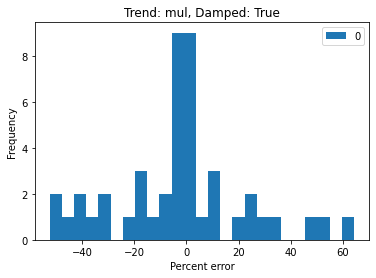

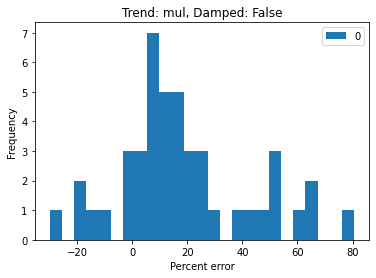

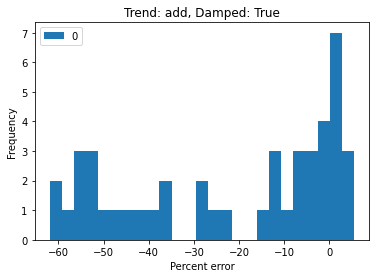

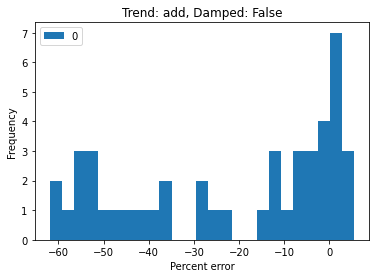

In [227]:
for (p, errors) in results:
    errors_df = pd.DataFrame(errors[-45:])
    print(p)
    print(errors_df.quantile([.05,.10,.50,.90,.95]))
    ax = (errors_df * 100).plot(kind='hist', bins=25, title='Trend: %s, Damped: %s' % (p[0],p[1]))
    ax.set_xlabel('Percent error')
    #print (p, errors)

In [220]:
for (p, errors) in results:
    print(errors)
    

[0.000827102563189408, 0.0007835708489019044, 0.0007423302774947071, 0.0007032602624990059, 0.000666246564102746, 0.0006311809551151626, 0.0005979609045139167, 0.0005664892776457986, 0.0005366740522085856, -0.49974578597541086, -0.4997591656610494, -0.4997718411526998, -0.4997838495132041, -0.499795225854728, -0.499806003441429, -0.4701135721295824, 1.0011991236069662e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.7777777777777778, -0.8888888888888888, -0.95, -0.9622641509433962, -0.9787234042553191, -0.9904306220095693, -0.9840879648412791, -0.8500491066185545, 1.9808879158826296, -0.862094307704213, -0.5905960186618483, 16.009772900271404, 0.19269354269333833, -0.3642730299422623, -0.4820465340616992, -0.5229206499212468, 0.34141418377412475, -0.15699113200977344, -0.3194494570145848, -0.4098649328663539, 0.09479558088763577, -0.3342160753667685, -0.383901397853629, -0.43656340045571457, -0.18710695183459652, -0.03259901771313753, 0.22236767666834864, 0.5057

In [216]:
len(results[0][1])

3168

In [212]:
a = [1]
b = []

In [213]:
b.append(a)

In [214]:
a=[2]

In [215]:
b

[[1]]